In [1]:
import json
import requests
import numpy as np
import pandas as pd
import matplotlib.pyplot as plt
import sys

sys.path.append("/Users/nickkeesey/Desktop/learning-dynamics-behavior/src/utils")
import behavior_utils as bu


from aind_behavior_gym.dynamic_foraging.task import CoupledBlockTask

refrence_df = pd.read_csv("/Users/nickkeesey/Desktop/learning-dynamics-behavior/data/filtered_data_20241107.csv")

/var/folders/mr/k7gx9xps333170k7zsggl4tw0000gn/T/ipykernel_9439/3494160968.py:14: DtypeWarning: Columns (6,7,8,11,26,27,28,29,30,133,134,149,150,151,152,153,154,155,156,157,158,159,160,161) have mixed types. Specify dtype option on import or set low_memory=False.
  refrence_df = pd.read_csv("/Users/nickkeesey/Desktop/learning-dynamics-behavior/data/filtered_data_20241107.csv")


In [2]:
refrence_df

,subject_id,session_date,nwb_suffix,session,rig,user_name,curriculum_name,curriculum_version,current_stage_actual,task,...,subject_genotype,fiber_probes,injections,task_type,virus,NM_recorded,results,results_location,session_time,docDB_status
0,743794,2024-11-06,173429,31.0,447-2-C,Bowen Tan,Uncoupled Baiting,2.3,GRADUATED,Uncoupled Baiting,...,wt/wt,[],[],Uncoupled Baiting,[],[],behavior_743794_2024-11-06_17-34-29_processed_...,s3://codeocean-s3datasetsbucket-1u41qdg42ur9/5...,17-34-29,2_uploaded and processed
1,741210,2024-11-06,173034,35.0,447-3-D,Bowen Tan,Uncoupled Baiting,2.3,GRADUATED,Uncoupled Baiting,...,wt/wt,[],[],Uncoupled Baiting,[],[],behavior_741210_2024-11-06_17-30-34_processed_...,s3://codeocean-s3datasetsbucket-1u41qdg42ur9/b...,17-30-34,2_uploaded and processed
2,728568,2024-11-06,172930,31.0,447-3-C,Bowen Tan,Uncoupled Baiting,2.3,GRADUATED,Uncoupled Baiting,...,Oi8(H11-CAG-Cas9)/Oi8(H11-CAG-Cas9),[],[],Uncoupled Baiting,[],[],behavior_728568_2024-11-06_17-29-30_processed_...,s3://codeocean-s3datasetsbucket-1u41qdg42ur9/1...,17-29-30,2_uploaded and processed
3,745505,2024-11-06,172625,11.0,447-1-D,Bowen Tan,Uncoupled Baiting,2.3,STAGE_FINAL,Uncoupled Baiting,...,Drd1a-Cre/wt;Adora2a-T2A-FlpO/wt;Ai231(TICL-Ch...,[],[],Uncoupled Baiting,[],[],behavior_745505_2024-11-06_17-26-25_processed_...,s3://codeocean-s3datasetsbucket-1u41qdg42ur9/d...,17-26-25,2_uploaded and processed
4,745502,2024-11-06,172512,15.0,447-1-C,Bowen Tan,Uncoupled Baiting,2.3,STAGE_FINAL,Uncoupled Baiting,...,Drd1a-Cre/wt;Adora2a-T2A-FlpO/wt;Ai231(TICL-Ch...,[],[],Uncoupled Baiting,[],[],behavior_745502_2024-11-06_17-25-12_processed_...,s3://codeocean-s3datasetsbucket-1u41qdg42ur9/9...,17-25-12,2_uploaded and processed
...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...
9078,453478,2019-06-26,164352,2.0,Training-Tower-2_bpod,Marton Rozsa,NaN,NaN,NaN,Coupled Baiting,...,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,0_not uploaded
9079,453476,2019-06-25,213144,1.0,Training-Tower-2_bpod,Marton Rozsa,NaN,NaN,NaN,Coupled Baiting,...,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,0_not uploaded
9080,453477,2019-06-25,201839,1.0,Training-Tower-2_bpod,Marton Rozsa,NaN,NaN,NaN,Coupled Baiting,...,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,0_not uploaded
9081,453475,2019-06-25,190736,1.0,Training-Tower-2_bpod,Marton Rozsa,NaN,NaN,NaN,Coupled Baiting,...,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,0_not uploaded


In [4]:
URL = "https://api.allenneuraldynamics-test.org/v1/behavior_analysis/mle_fitting"

filter = {
    # "nwb_name": "720956_2024-07-17_13-02-47.nwb",  # Session id,
    "analysis_results.fit_settings.agent_alias": "QLearning_L2F1_softmax",  # Hattori2019 model
}
projection = {
    "analysis_results.params": 1,
    "nwb_name": 1,  # Include session ID in projection
    "_id": 0,
}
response = requests.get(URL, params={"filter": json.dumps(filter), "projection": json.dumps(projection)})
record_dict = response.json()

# Fitted parameters
# params = record_dict["analysis_results"]["params"]

# First, let's check what we're getting back
print("Response content:", record_dict)

# Then modify the DataFrame creation to handle the response correctly
if isinstance(record_dict, list):
    # If it's already a list of records
    df = pd.DataFrame([{
        **x['analysis_results']['params'],
        'session_id': x['nwb_name']
    } for x in record_dict])
else:
    # If it's a single record or different format, we need to handle it differently
    df = pd.DataFrame([{
        **record_dict.get('analysis_results', {}).get('params', {}),
        'session_id': record_dict.get('nwb_name', '')
    }])

Response content: [{'nwb_name': '721403_2024-08-09_08-39-12.nwb', 'analysis_results': {'params': {'learn_rate_rew': 1, 'learn_rate_unrew': 0.09430528031180078, 'forget_rate_unchosen': 0.3642237748750471, 'biasL': -0.022018738856473194, 'softmax_inverse_temperature': 3.927836240143752}}}, {'nwb_name': '750102_2024-08-29_08-56-39.nwb', 'analysis_results': {'params': {'learn_rate_rew': 0.816177860358848, 'learn_rate_unrew': 0.17002913431114164, 'forget_rate_unchosen': 1, 'biasL': -0.0314762209468523, 'softmax_inverse_temperature': 4.312851167534833}}}, {'nwb_name': '713855_2024-06-05_14-22-22.nwb', 'analysis_results': {'params': {'learn_rate_rew': 0.6020539723308247, 'learn_rate_unrew': 0.18136682705953858, 'forget_rate_unchosen': 1, 'biasL': 0.4976172554181193, 'softmax_inverse_temperature': 3.2142066735744157}}}, {'nwb_name': '716325_2024-04-18_08-51-14.nwb', 'analysis_results': {'params': {'learn_rate_rew': 1, 'learn_rate_unrew': 0.1766834427472519, 'forget_rate_unchosen': 0.9319622628

In [5]:
# Split session_id into subject_id and session_date
df[['subject_id', 'session_date']] = df['session_id'].str.extract(r'(\d+)_(\d{4}-\d{2}-\d{2})')

# Drop the original session_id column
df = df.drop('session_id', axis=1)

# Reorder columns to put subject_id and session_date first
cols = ['subject_id', 'session_date'] + [col for col in df.columns if col not in ['subject_id', 'session_date']]
df = df[cols]

# Convert subject_id to int64 and session_date to datetime
df['subject_id'] = df['subject_id'].astype('int64')
df['session_date'] = pd.to_datetime(df['session_date'])

df.sort_values(by=['subject_id', 'session_date'], inplace=True)

df

,subject_id,session_date,learn_rate_rew,learn_rate_unrew,forget_rate_unchosen,biasL,softmax_inverse_temperature
734,662914,2023-09-19,0.726761,0.015975,0.496008,-0.131255,3.666177
3002,662914,2023-09-21,0.425101,0.075546,0.877673,-0.400069,4.693508
2024,662914,2023-09-22,0.517742,0.130047,0.441506,0.203065,4.446999
2066,662914,2023-09-25,1.000000,0.022667,0.694308,-0.087596,3.063420
1404,662914,2023-09-29,0.608351,0.206013,0.484623,0.523089,5.679637
...,...,...,...,...,...,...,...
5136,769887,2024-11-06,0.237342,0.077281,0.537723,0.307139,4.601573
4560,769888,2024-11-04,1.000000,0.429955,1.000000,0.053724,3.914787
4988,769888,2024-11-07,0.837324,0.155720,0.701916,0.095278,2.442241
4931,769888,2024-11-08,0.972369,0.328508,1.000000,0.289602,2.214779


In [6]:
print(len(df['subject_id'].unique()))

270


In [7]:
merged_df = bu.merge_dataframes_subject_id(refrence_df, df)
merged_df

,subject_id,session_date,nwb_suffix,session,rig,user_name,curriculum_name,curriculum_version,current_stage_actual,task,...,NM_recorded,results,results_location,session_time,docDB_status,learn_rate_rew,learn_rate_unrew,forget_rate_unchosen,biasL,softmax_inverse_temperature
0,743794,2024-11-06,173429,31.0,447-2-C,Bowen Tan,Uncoupled Baiting,2.3,GRADUATED,Uncoupled Baiting,...,[],behavior_743794_2024-11-06_17-34-29_processed_...,s3://codeocean-s3datasetsbucket-1u41qdg42ur9/5...,17-34-29,2_uploaded and processed,0.059010,0.268223,0.438583,-1.077800,13.387259
1,741210,2024-11-06,173034,35.0,447-3-D,Bowen Tan,Uncoupled Baiting,2.3,GRADUATED,Uncoupled Baiting,...,[],behavior_741210_2024-11-06_17-30-34_processed_...,s3://codeocean-s3datasetsbucket-1u41qdg42ur9/b...,17-30-34,2_uploaded and processed,0.479262,0.267408,0.474814,0.845188,5.494346
2,728568,2024-11-06,172930,31.0,447-3-C,Bowen Tan,Uncoupled Baiting,2.3,GRADUATED,Uncoupled Baiting,...,[],behavior_728568_2024-11-06_17-29-30_processed_...,s3://codeocean-s3datasetsbucket-1u41qdg42ur9/1...,17-29-30,2_uploaded and processed,0.437320,0.071188,0.611688,-0.551877,2.700772
3,745505,2024-11-06,172625,11.0,447-1-D,Bowen Tan,Uncoupled Baiting,2.3,STAGE_FINAL,Uncoupled Baiting,...,[],behavior_745505_2024-11-06_17-26-25_processed_...,s3://codeocean-s3datasetsbucket-1u41qdg42ur9/d...,17-26-25,2_uploaded and processed,1.000000,0.091731,0.401779,0.406104,2.135829
4,745502,2024-11-06,172512,15.0,447-1-C,Bowen Tan,Uncoupled Baiting,2.3,STAGE_FINAL,Uncoupled Baiting,...,[],behavior_745502_2024-11-06_17-25-12_processed_...,s3://codeocean-s3datasetsbucket-1u41qdg42ur9/9...,17-25-12,2_uploaded and processed,0.097319,0.206368,0.535354,1.344307,10.274541
...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...
5249,671087,2023-07-10,0,2.0,Tower-1,Travis Ramirez,NaN,NaN,NaN,Coupled Baiting,...,NaN,NaN,NaN,NaN,0_not uploaded,0.848621,0.032129,0.259678,0.347903,2.549827
5250,668463,2023-07-07,1,1.0,Tower-1,Lucas Kinsey,NaN,NaN,NaN,Coupled Baiting,...,NaN,NaN,NaN,NaN,0_not uploaded,0.264488,0.229240,0.512589,-0.064148,2.020394
5251,668463,2023-07-07,1,1.0,Tower-1,Lucas Kinsey,NaN,NaN,NaN,Coupled Baiting,...,NaN,NaN,NaN,NaN,0_not uploaded,0.354576,0.032675,0.550530,-0.860623,3.164487
5252,671087,2023-07-06,0,1.0,Tower-1,Travis Ramirez,NaN,NaN,NaN,Coupled Baiting,...,NaN,NaN,NaN,NaN,0_not uploaded,0.104341,0.158354,0.339378,-0.205902,3.689303


In [8]:
merged_df['curriculum_name'].unique()

array(['Uncoupled Baiting', nan, 'Uncoupled Without Baiting',
       'Coupled Baiting'], dtype=object)

In [9]:
curriculum_name = 'Coupled Baiting'

final_df = merged_df[merged_df['curriculum_name'] == curriculum_name]
final_df

,subject_id,session_date,nwb_suffix,session,rig,user_name,curriculum_name,curriculum_version,current_stage_actual,task,...,NM_recorded,results,results_location,session_time,docDB_status,learn_rate_rew,learn_rate_unrew,forget_rate_unchosen,biasL,softmax_inverse_temperature
1519,708031,2024-08-30,85034,18.0,447-1-D,Huy Nguyen,Coupled Baiting,2.3,STAGE_FINAL,Coupled Baiting,...,[],NaN,NaN,08-50-34,1_uploaded but not processed,0.801103,0.085424,0.784820,-0.292962,3.839600
1546,708031,2024-08-29,84701,17.0,447-1-D,Huy Nguyen,Coupled Baiting,2.3,STAGE_FINAL,Coupled Baiting,...,[],behavior_708031_2024-08-29_08-47-01_processed_...,s3://codeocean-s3datasetsbucket-1u41qdg42ur9/0...,08-47-01,2_uploaded and processed,0.604507,0.034036,0.822338,-0.594164,4.218502
1559,708027,2024-08-28,133212,20.0,447-2-D,Jaimie Kenney,Coupled Baiting,2.3,STAGE_FINAL,Coupled Baiting,...,[],behavior_708027_2024-08-28_13-32-12_processed_...,s3://codeocean-s3datasetsbucket-1u41qdg42ur9/8...,13-32-12,2_uploaded and processed,1.000000,0.000000,0.319569,-0.746276,1.836122
1565,708031,2024-08-28,84152,16.0,447-1-D,Huy Nguyen,Coupled Baiting,2.3,STAGE_FINAL,Coupled Baiting,...,[],behavior_708031_2024-08-28_08-41-52_processed_...,s3://codeocean-s3datasetsbucket-1u41qdg42ur9/b...,08-41-52,2_uploaded and processed,0.633823,0.121445,0.386134,-0.469562,5.571148
1592,708027,2024-08-26,133705,19.0,447-2-D,Jaimie Kenney,Coupled Baiting,2.3,STAGE_3,Coupled Baiting,...,[],behavior_708027_2024-08-26_13-37-05_processed_...,s3://codeocean-s3datasetsbucket-1u41qdg42ur9/8...,13-37-05,2_uploaded and processed,0.312050,0.337839,0.684059,-0.184284,5.603611
...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...
4205,697929,2024-02-23,85125,2.0,447-3-D,Ella Hilton,Coupled Baiting,0.1,STAGE_1,Coupled Baiting,...,NaN,NaN,NaN,NaN,0_not uploaded,0.180059,0.456872,0.764101,0.294458,4.072146
4206,702200,2024-02-23,84849,3.0,447-2-D,Ella Hilton,Coupled Baiting,0.1,STAGE_1,Coupled Baiting,...,NaN,NaN,NaN,NaN,0_not uploaded,0.265814,0.376120,0.813799,0.189069,3.706857
4228,697929,2024-02-22,83830,1.0,447-3-D,Ella Hilton,Coupled Baiting,0.1,STAGE_1,Coupled Baiting,...,NaN,NaN,NaN,NaN,0_not uploaded,0.574583,1.000000,1.000000,-0.358331,0.801689
4229,702200,2024-02-22,83612,2.0,447-2-D,Ella Hilton,Coupled Baiting,0.1,STAGE_1,Coupled Baiting,...,NaN,NaN,NaN,NaN,0_not uploaded,0.267723,0.352326,0.436895,0.333240,2.850529


In [10]:
from fc_environments import run_task_env
import seaborn as sns

results_df = run_task_env(final_df, n_sims=1000)
results_df

Running 1000 simulations for parameter set 1520/327 (STAGE_FINAL): 100%|██████████| 1000/1000 [00:14<00:00, 70.44it/s]
Running 1000 simulations for parameter set 1547/327 (STAGE_FINAL): 100%|██████████| 1000/1000 [00:13<00:00, 71.54it/s]
Running 1000 simulations for parameter set 1560/327 (STAGE_FINAL): 100%|██████████| 1000/1000 [00:14<00:00, 71.21it/s]
Running 1000 simulations for parameter set 1566/327 (STAGE_FINAL): 100%|██████████| 1000/1000 [00:14<00:00, 70.35it/s]
Running 1000 simulations for parameter set 1593/327 (STAGE_3): 100%|██████████| 1000/1000 [00:11<00:00, 90.82it/s]
Running 1000 simulations for parameter set 1602/327 (STAGE_FINAL): 100%|██████████| 1000/1000 [00:14<00:00, 67.25it/s]
Running 1000 simulations for parameter set 1611/327 (STAGE_FINAL): 100%|██████████| 1000/1000 [00:14<00:00, 67.75it/s]
Running 1000 simulations for parameter set 1619/327 (STAGE_FINAL): 100%|██████████| 1000/1000 [00:14<00:00, 69.21it/s]
Running 1000 simulations for parameter set 1626/327 

Running 1000 simulations for parameter set 2041/327 (STAGE_2): 100%|██████████| 1000/1000 [00:08<00:00, 123.35it/s]
Running 1000 simulations for parameter set 2042/327 (STAGE_1): 100%|██████████| 1000/1000 [00:08<00:00, 124.18it/s]
Running 1000 simulations for parameter set 2053/327 (STAGE_2): 100%|██████████| 1000/1000 [00:08<00:00, 118.41it/s]
Running 1000 simulations for parameter set 2054/327 (STAGE_1): 100%|██████████| 1000/1000 [00:08<00:00, 122.65it/s]
Running 1000 simulations for parameter set 2057/327 (STAGE_1): 100%|██████████| 1000/1000 [00:08<00:00, 119.50it/s]
Running 1000 simulations for parameter set 2065/327 (GRADUATED): 100%|██████████| 1000/1000 [00:16<00:00, 59.57it/s]
Running 1000 simulations for parameter set 2066/327 (GRADUATED): 100%|██████████| 1000/1000 [00:16<00:00, 61.15it/s]
Running 1000 simulations for parameter set 2076/327 (STAGE_1): 100%|██████████| 1000/1000 [00:07<00:00, 125.30it/s]
Running 1000 simulations for parameter set 2077/327 (STAGE_1): 100%|██

Running 1000 simulations for parameter set 2138/327 (STAGE_2): 100%|██████████| 1000/1000 [00:08<00:00, 121.70it/s]
Running 1000 simulations for parameter set 2146/327 (GRADUATED): 100%|██████████| 1000/1000 [00:17<00:00, 58.72it/s]
Running 1000 simulations for parameter set 2148/327 (GRADUATED): 100%|██████████| 1000/1000 [00:17<00:00, 56.81it/s]
Running 1000 simulations for parameter set 2161/327 (STAGE_1): 100%|██████████| 1000/1000 [00:07<00:00, 126.21it/s]
Running 1000 simulations for parameter set 2166/327 (GRADUATED): 100%|██████████| 1000/1000 [00:16<00:00, 60.63it/s]
Running 1000 simulations for parameter set 2168/327 (GRADUATED): 100%|██████████| 1000/1000 [00:16<00:00, 60.25it/s]
Running 1000 simulations for parameter set 2181/327 (STAGE_1): 100%|██████████| 1000/1000 [00:07<00:00, 126.56it/s]
Running 1000 simulations for parameter set 2182/327 (STAGE_1): 100%|██████████| 1000/1000 [00:07<00:00, 125.10it/s]
Running 1000 simulations for parameter set 2199/327 (GRADUATED): 100

Running 1000 simulations for parameter set 2217/327 (GRADUATED): 100%|██████████| 1000/1000 [00:16<00:00, 61.13it/s]
Running 1000 simulations for parameter set 2226/327 (GRADUATED): 100%|██████████| 1000/1000 [00:16<00:00, 60.67it/s]
Running 1000 simulations for parameter set 2230/327 (GRADUATED): 100%|██████████| 1000/1000 [00:16<00:00, 60.20it/s]
Running 1000 simulations for parameter set 2252/327 (GRADUATED): 100%|██████████| 1000/1000 [00:18<00:00, 55.06it/s]
Running 1000 simulations for parameter set 2254/327 (GRADUATED): 100%|██████████| 1000/1000 [00:19<00:00, 51.68it/s]
Running 1000 simulations for parameter set 2259/327 (STAGE_FINAL): 100%|██████████| 1000/1000 [00:15<00:00, 64.19it/s]
Running 1000 simulations for parameter set 2271/327 (STAGE_2): 100%|██████████| 1000/1000 [00:08<00:00, 117.60it/s]
Running 1000 simulations for parameter set 2272/327 (STAGE_2): 100%|██████████| 1000/1000 [00:08<00:00, 120.06it/s]
Running 1000 simulations for parameter set 2275/327 (STAGE_FINAL

Running 1000 simulations for parameter set 2533/327 (STAGE_3): 100%|██████████| 1000/1000 [00:11<00:00, 87.10it/s]
Running 1000 simulations for parameter set 2536/327 (STAGE_FINAL): 100%|██████████| 1000/1000 [00:14<00:00, 66.90it/s]
Running 1000 simulations for parameter set 2545/327 (STAGE_3): 100%|██████████| 1000/1000 [00:11<00:00, 88.56it/s]
Running 1000 simulations for parameter set 2553/327 (STAGE_2): 100%|██████████| 1000/1000 [00:08<00:00, 111.33it/s]
Running 1000 simulations for parameter set 2556/327 (STAGE_FINAL): 100%|██████████| 1000/1000 [00:16<00:00, 60.42it/s]
Running 1000 simulations for parameter set 2571/327 (STAGE_2): 100%|██████████| 1000/1000 [00:10<00:00, 97.39it/s]
Running 1000 simulations for parameter set 2579/327 (STAGE_1): 100%|██████████| 1000/1000 [00:08<00:00, 119.53it/s]
Running 1000 simulations for parameter set 2582/327 (STAGE_3): 100%|██████████| 1000/1000 [00:11<00:00, 86.08it/s]
Running 1000 simulations for parameter set 2595/327 (STAGE_1): 100%|██

Running 1000 simulations for parameter set 2720/327 (STAGE_FINAL): 100%|██████████| 1000/1000 [00:15<00:00, 63.44it/s]
Running 1000 simulations for parameter set 2730/327 (STAGE_3): 100%|██████████| 1000/1000 [00:12<00:00, 82.00it/s]
Running 1000 simulations for parameter set 2737/327 (STAGE_2): 100%|██████████| 1000/1000 [00:08<00:00, 121.32it/s]
Running 1000 simulations for parameter set 2743/327 (STAGE_3): 100%|██████████| 1000/1000 [00:11<00:00, 86.93it/s]
Running 1000 simulations for parameter set 2759/327 (STAGE_1): 100%|██████████| 1000/1000 [00:07<00:00, 127.71it/s]
Running 1000 simulations for parameter set 2760/327 (STAGE_FINAL): 100%|██████████| 1000/1000 [00:14<00:00, 69.03it/s]
Running 1000 simulations for parameter set 2768/327 (STAGE_3): 100%|██████████| 1000/1000 [00:11<00:00, 87.49it/s]
Running 1000 simulations for parameter set 2783/327 (STAGE_3): 100%|██████████| 1000/1000 [00:11<00:00, 87.66it/s]
Running 1000 simulations for parameter set 2787/327 (STAGE_2): 100%|██

Running 1000 simulations for parameter set 2850/327 (STAGE_3): 100%|██████████| 1000/1000 [00:11<00:00, 86.61it/s]
Running 1000 simulations for parameter set 2859/327 (STAGE_2): 100%|██████████| 1000/1000 [00:09<00:00, 108.20it/s]
Running 1000 simulations for parameter set 2874/327 (STAGE_3): 100%|██████████| 1000/1000 [00:11<00:00, 84.72it/s]
Running 1000 simulations for parameter set 2894/327 (STAGE_FINAL): 100%|██████████| 1000/1000 [00:15<00:00, 65.93it/s]
Running 1000 simulations for parameter set 2917/327 (STAGE_FINAL): 100%|██████████| 1000/1000 [00:15<00:00, 65.41it/s]
Running 1000 simulations for parameter set 2930/327 (STAGE_3): 100%|██████████| 1000/1000 [00:11<00:00, 84.66it/s]
Running 1000 simulations for parameter set 2958/327 (STAGE_2): 100%|██████████| 1000/1000 [00:08<00:00, 122.75it/s]
Running 1000 simulations for parameter set 2977/327 (STAGE_2): 100%|██████████| 1000/1000 [00:08<00:00, 122.39it/s]
Running 1000 simulations for parameter set 3003/327 (STAGE_3): 100%|█

Running 1000 simulations for parameter set 3847/327 (GRADUATED): 100%|██████████| 1000/1000 [00:16<00:00, 60.61it/s]
Running 1000 simulations for parameter set 3865/327 (GRADUATED): 100%|██████████| 1000/1000 [00:16<00:00, 59.73it/s]
Running 1000 simulations for parameter set 3879/327 (GRADUATED): 100%|██████████| 1000/1000 [00:16<00:00, 60.51it/s]
Running 1000 simulations for parameter set 3907/327 (GRADUATED): 100%|██████████| 1000/1000 [00:16<00:00, 59.97it/s]
Running 1000 simulations for parameter set 3925/327 (GRADUATED): 100%|██████████| 1000/1000 [00:16<00:00, 59.62it/s]
Running 1000 simulations for parameter set 3928/327 (STAGE_FINAL): 100%|██████████| 1000/1000 [00:14<00:00, 67.16it/s]
Running 1000 simulations for parameter set 3945/327 (STAGE_3): 100%|██████████| 1000/1000 [00:11<00:00, 88.65it/s]
Running 1000 simulations for parameter set 3946/327 (STAGE_FINAL): 100%|██████████| 1000/1000 [00:15<00:00, 66.62it/s]
Running 1000 simulations for parameter set 3969/327 (STAGE_3):

,parameter_set,stage,simulation,foraging_efficiency,foraging_efficiency_random_seed,foraging_choice_local,foraging_choice_global,random_seed,num_trials,block_min,block_max,block_beta,learn_rate_rew,learn_rate_unrew,forget_rate_unchosen,biasL,softmax_inverse_temperature
0,1519,STAGE_FINAL,0,0.640402,0.628743,-0.037884,0.111429,42,400,20,60,20,0.801103,0.085424,0.78482,-0.292962,3.839600
1,1519,STAGE_FINAL,1,0.720820,0.781457,0.227976,0.204286,43,400,20,60,20,0.801103,0.085424,0.78482,-0.292962,3.839600
2,1519,STAGE_FINAL,2,0.745015,0.699422,0.132631,0.084286,44,400,20,60,20,0.801103,0.085424,0.78482,-0.292962,3.839600
3,1519,STAGE_FINAL,3,0.665554,0.681250,0.060099,0.098571,45,400,20,60,20,0.801103,0.085424,0.78482,-0.292962,3.839600
4,1519,STAGE_FINAL,4,0.768941,0.777778,0.014523,0.132143,46,400,20,60,20,0.801103,0.085424,0.78482,-0.292962,3.839600
...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...
314995,4251,STAGE_1,995,0.743750,0.695906,0.343510,0.320000,1037,200,10,20,5,1.000000,0.415064,1.00000,-0.144400,1.654176
314996,4251,STAGE_1,996,0.662500,0.675159,0.258578,0.290000,1038,200,10,20,5,1.000000,0.415064,1.00000,-0.144400,1.654176
314997,4251,STAGE_1,997,0.712500,0.708075,0.263800,0.290000,1039,200,10,20,5,1.000000,0.415064,1.00000,-0.144400,1.654176
314998,4251,STAGE_1,998,0.787500,0.777778,0.377137,0.470000,1040,200,10,20,5,1.000000,0.415064,1.00000,-0.144400,1.654176


In [35]:
# Preprocessing
stage_order = ['STAGE_1', 'STAGE_2', 'STAGE_3', 'STAGE_FINAL', 'GRADUATED']
results_df['stage'] = pd.Categorical(results_df['stage'], categories=stage_order)

<Axes: xlabel='stage', ylabel='foraging_choice_local'>

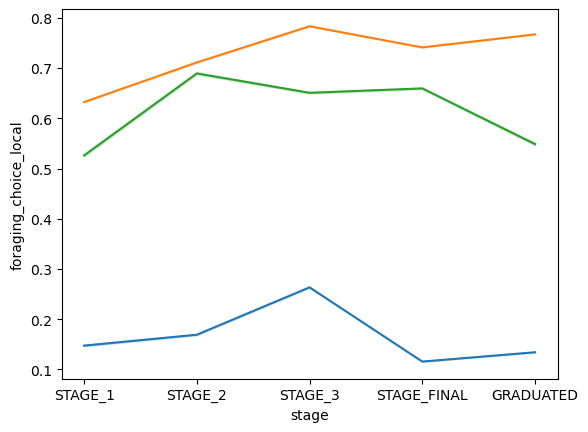

In [38]:
sns.lineplot(results_df, x='stage', y='foraging_choice_local')
sns.lineplot(results_df, x='stage', y='foraging_efficiency')
sns.lineplot(results_df, x='stage', y='learn_rate_rew')

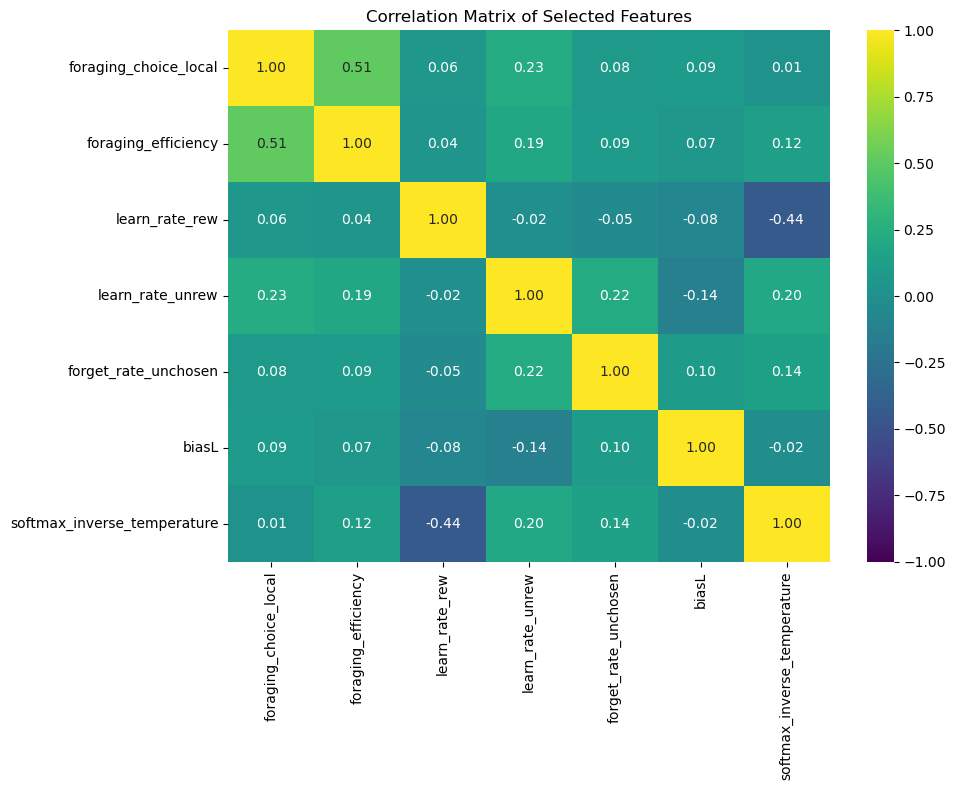

In [40]:
# Select features for correlation matrix
features_to_correlate = [
    'foraging_choice_local', 
    'foraging_efficiency',
    'learn_rate_rew',
    'learn_rate_unrew',
    'forget_rate_unchosen',
    'biasL',
    'softmax_inverse_temperature'
]

# Calculate correlation matrix for selected features
correlation_matrix = results_df[features_to_correlate].corr()

# Create heatmap
plt.figure(figsize=(10, 8))
sns.heatmap(correlation_matrix, 
            annot=True,
            cmap='viridis',
            vmin=-1, 
            vmax=1,
            center=0,
            fmt='.2f')
plt.title('Correlation Matrix of Selected Features')
plt.tight_layout()


/var/folders/mr/k7gx9xps333170k7zsggl4tw0000gn/T/ipykernel_9439/190482750.py:9: FutureWarning: The default value of observed=False is deprecated and will change to observed=True in a future version of pandas. Specify observed=False to silence this warning and retain the current behavior
  fc_pivot = pd.pivot_table(
/var/folders/mr/k7gx9xps333170k7zsggl4tw0000gn/T/ipykernel_9439/190482750.py:17: FutureWarning: The default value of observed=False is deprecated and will change to observed=True in a future version of pandas. Specify observed=False to silence this warning and retain the current behavior
  fe_pivot = pd.pivot_table(


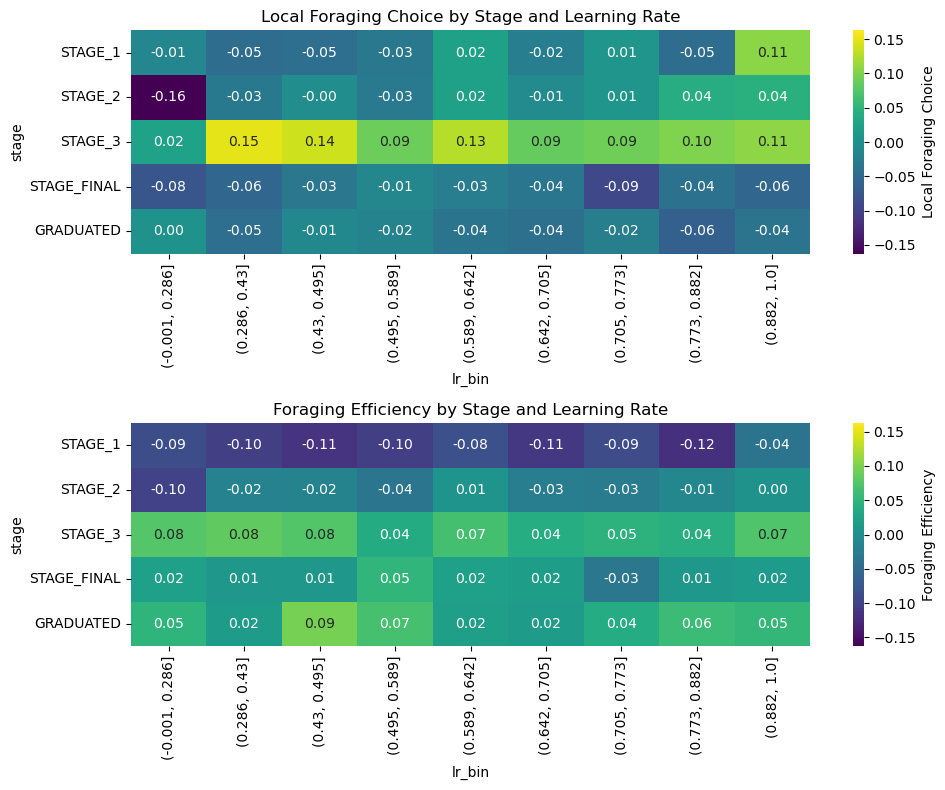

In [29]:
import seaborn as sns


results_df['lr_bin'] = pd.qcut(results_df['learn_rate_rew'], q=10, duplicates='drop')
stage_order = ['STAGE_1', 'STAGE_2', 'STAGE_3', 'STAGE_FINAL', 'GRADUATED']


# Create pivot tables for both metrics
fc_pivot = pd.pivot_table(
    results_df, 
    values='foraging_choice_local',
    index='stage',
    columns='lr_bin',
    aggfunc='mean'
).reindex(stage_order)

fe_pivot = pd.pivot_table(
    results_df, 
    values='foraging_efficiency',
    index='stage',
    columns='lr_bin',
    aggfunc='mean'
).reindex(stage_order)

# Subtract mean to center around 0
fc_pivot = fc_pivot - fc_pivot.values.mean()
fe_pivot = fe_pivot - fe_pivot.values.mean()

# Set symmetric scale based on largest absolute deviation
vmax = max(abs(fc_pivot.values.max()), abs(fe_pivot.values.max()),
           abs(fc_pivot.values.min()), abs(fe_pivot.values.min()))
vmin = -vmax

# Plot heatmaps
fig, (ax1, ax2) = plt.subplots(2, 1, figsize=(10, 8))

sns.heatmap(fc_pivot, ax=ax1, cmap='viridis', 
            annot=True, fmt='.2f', cbar_kws={'label': 'Local Foraging Choice'},
            vmin=vmin, vmax=vmax)
ax1.set_title('Local Foraging Choice by Stage and Learning Rate')

sns.heatmap(fe_pivot, ax=ax2, cmap='viridis',
            annot=True, fmt='.2f', cbar_kws={'label': 'Foraging Efficiency'},
            vmin=vmin, vmax=vmax)
ax2.set_title('Foraging Efficiency by Stage and Learning Rate')

plt.tight_layout()
plt.show()


In [13]:
# Starting with Coupled Baiting Block Task

stage_vector = ['STAGE_1', 'STAGE_2', 'STAGE_3', 'STAGE_FINAL', 'GRADUATED']

# Base off streamlit or bonsai data?

STAGE_1 = CoupledBlockTask(
    reward_baiting=True, 
    num_trials= 200,
    block_min = 10,
    block_max = 20,
    block_beta = 5,
    p_reward_pairs = [
        [0.8, 0]
    ],
    seed=42
)

STAGE_2 = CoupledBlockTask(
    reward_baiting=True, 
    num_trials= 200,
    block_min = 10,
    block_max = 40,
    block_beta = 10,
    p_reward_pairs = [
        [0.55, 0.05]
    ],
    seed=42
)

STAGE_3 = CoupledBlockTask(
    reward_baiting=True, 
    num_trials= 300,
    block_min = 20,
    block_max = 60,
    block_beta = 20,
    p_reward_pairs = [
        [0.4, 0.05]
    ],
    seed=42
)

STAGE_FINAL = CoupledBlockTask(
    reward_baiting=True, 
    num_trials= 400,
    block_min = 20,
    block_max = 60,
    block_beta = 20,
    p_reward_pairs = [
        [0.4, 0.05],
        [0.25, 0.2],
        [0.1, 0.35],
        [0.3, 0.15]
    ],
    seed=42
)

GRADUATED = CoupledBlockTask(
    reward_baiting=True, 
    num_trials= 450,
    block_min = 20,
    block_max = 60,
    block_beta = 20,
    p_reward_pairs = [
        [0.4, 0.05],
        [0.25, 0.2],
        [0.1, 0.35],
        [0.3, 0.15]
    ],
    seed=42
)

tasks = {
    'STAGE_1': STAGE_1,
    'STAGE_2': STAGE_2,
    'STAGE_3': STAGE_3,
    'STAGE_FINAL': STAGE_FINAL,
    'GRADUATED': GRADUATED
}

/var/folders/mr/k7gx9xps333170k7zsggl4tw0000gn/T/ipykernel_9439/2696116307.py:6: FutureWarning: The default of observed=False is deprecated and will be changed to True in a future version of pandas. Pass observed=False to retain current behavior or observed=True to adopt the future default and silence this warning.
  mean_by_bin = results_df.groupby(['stage', 'lr_bin']).agg({


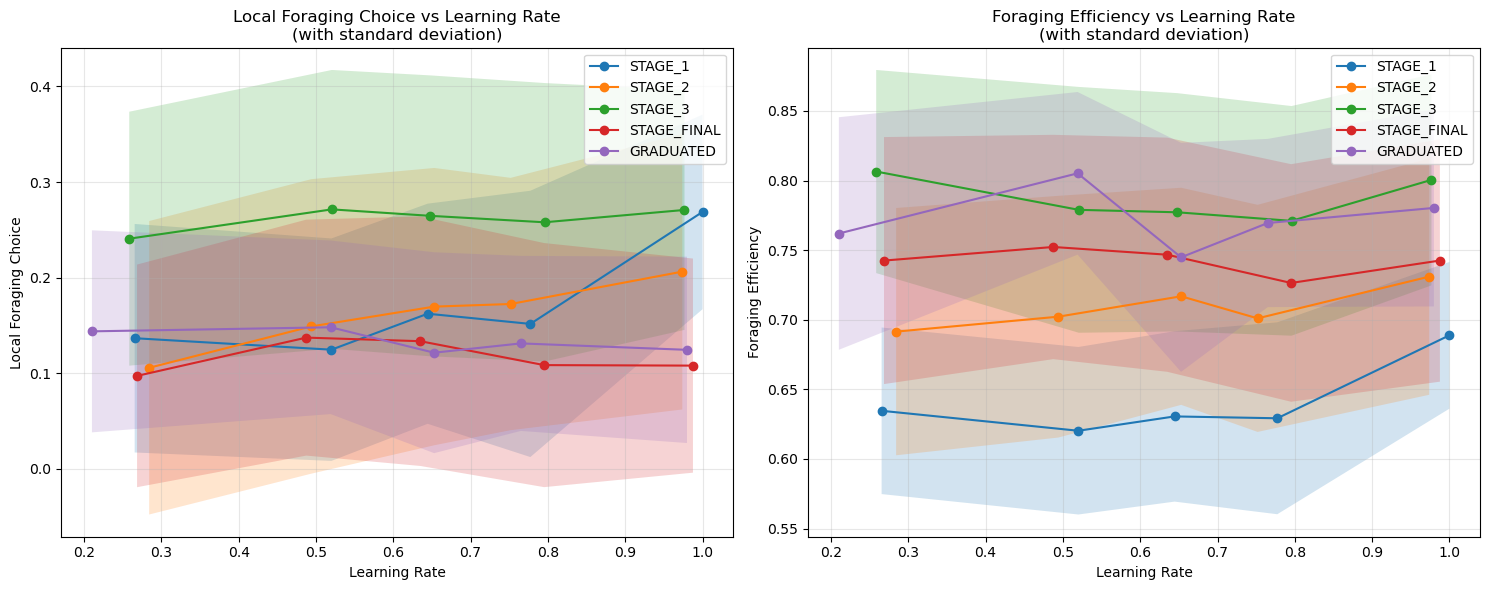

In [14]:
# 1. Line plot with confidence intervals
plt.figure(figsize=(15, 6))

# Create bins for learning rate to smooth the plot
results_df['lr_bin'] = pd.qcut(results_df['learn_rate_rew'], q=5, duplicates='drop')
mean_by_bin = results_df.groupby(['stage', 'lr_bin']).agg({
    'learn_rate_rew': 'mean',
    'foraging_choice_local': ['mean', 'std'],
    'foraging_efficiency': ['mean', 'std']
}).reset_index()

# Plot for local metric
plt.subplot(1, 2, 1)
for stage in tasks.keys():
    stage_data = mean_by_bin[mean_by_bin['stage'] == stage]
    plt.plot(stage_data[('learn_rate_rew', 'mean')], 
             stage_data[('foraging_choice_local', 'mean')], 
             label=stage, marker='o')
    plt.fill_between(stage_data[('learn_rate_rew', 'mean')],
                     stage_data[('foraging_choice_local', 'mean')] - stage_data[('foraging_choice_local', 'std')],
                     stage_data[('foraging_choice_local', 'mean')] + stage_data[('foraging_choice_local', 'std')],
                     alpha=0.2)

plt.xlabel('Learning Rate')
plt.ylabel('Local Foraging Choice')
plt.title('Local Foraging Choice vs Learning Rate\n(with standard deviation)')
plt.legend()
plt.grid(True, alpha=0.3)

# Plot for foraging efficiency
plt.subplot(1, 2, 2)
for stage in tasks.keys():
    stage_data = mean_by_bin[mean_by_bin['stage'] == stage]
    plt.plot(stage_data[('learn_rate_rew', 'mean')], 
             stage_data[('foraging_efficiency', 'mean')], 
             label=stage, marker='o')
    plt.fill_between(stage_data[('learn_rate_rew', 'mean')],
                     stage_data[('foraging_efficiency', 'mean')] - stage_data[('foraging_efficiency', 'std')],
                     stage_data[('foraging_efficiency', 'mean')] + stage_data[('foraging_efficiency', 'std')],
                     alpha=0.2)

plt.xlabel('Learning Rate')
plt.ylabel('Foraging Efficiency')
plt.title('Foraging Efficiency vs Learning Rate\n(with standard deviation)')
plt.legend()
plt.grid(True, alpha=0.3)

plt.tight_layout()
plt.show()